In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import AutoMinorLocator
import xcorr

In [3]:
plt.rcParams.update({'font.size': 9})

In [4]:
root = '../datasets'

In [5]:
ds1 = xcorr.read(f'{root}/lfs/cc__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2015015.nc')
ds2 = xcorr.read(f'{root}/lfs/cc__IM.H03S[1-3]..EDH-IU.RAR.10.BH[RZ]__2015228.nc')

In [6]:
def postprocess(ds, offset=0):
    """
    """
    # extract time_offset and pair_offset
    delay = -(ds.pair_offset + ds.time_offset + offset)

    # extract and postprocess cc
    cc = (
        ds.cc.where((ds.status == 1), drop=True)
        .signal.unbias()
        .signal.demean()
        .signal.taper(max_length=5.)  # timeshift phase wrapping
        .signal.timeshift(delay=delay, dim='lag', fast=True)
        .signal.filter(frequency=3., btype='highpass', order=2)
        .signal.taper(max_length=3/2)  # filter artefacts
    )

    s = cc.where(
        (cc.lag >= ds.distance.mean()/1.50) &
        (cc.lag <= ds.distance.mean()/1.46),
        drop=True,
    )
    
    Spsd = s.signal.spectrogram(duration=2.5, padding_factor=4)
    Scwt = s.signal.scaleogram(wavelet="cmor1.0-3.0", scales=500, freq_lim=(1.5, 20.))
    
    return cc, s, Spsd, Scwt

In [7]:
cc1, signal1, psd1, cwt1 = postprocess(ds1)

In [8]:
offset = 0.  # [s]
cc2, signal2, psd2, cwt2 = postprocess(ds2, offset=offset)

<IPython.core.display.Javascript object>


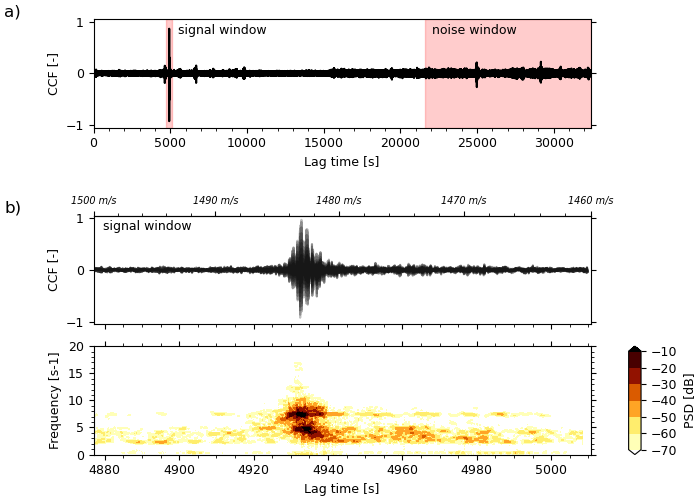

In [9]:
pair = ds1.pair[(ds1.pair.str.contains('BHZ')) & (ds1.pair.str.contains('H03S1'))][0]
d = ds1.distance.sel(pair=pair).values.item()*1000

fig = plt.figure(constrained_layout=True, figsize=(7, 5))

gs = GridSpec(3, 2, figure=fig, width_ratios=(40, 1))
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])

ylim = (-1.05, 1.05)
factor = signal1.signal.abs().max()

# entire period
(cc1.sel(pair=pair)/factor).isel(time=0, lag=range(0, cc1.lag.size, 2)).plot.line(
    x='lag', color='k', add_legend=False, ax=ax1
)
ax1.tick_params(labelbottom=True, labelleft=True)
ax1.set_title(None)
ax1.set_xlim(cc1.lag[0], cc1.lag[-1])
ax1.set_ylabel('CCF [-]')
ax1.set_ylim(*ylim)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_ticks_position('both')

ax1.fill_between([4750, 5100], ax1.get_ylim()[0], ax1.get_ylim()[1],
                 alpha=0.2, color='red')
ax1.fill_between([3600*6, 3600*9], ax1.get_ylim()[0], ax1.get_ylim()[1],
                 alpha=0.2, color='red')
ax1.text(0.17, 0.96, 'signal window', transform=ax1.transAxes, ha='left', va='top')
ax1.text(0.68, 0.96, 'noise window', transform=ax1.transAxes, ha='left', va='top')
ax1.text(-0.18, 1, 'a)', transform=ax1.transAxes, ha='left', va='bottom', fontsize=12, fontweight='medium')

# signal
(signal1.sel(pair=pair)/factor).plot.line(x='lag', color='k', add_legend=False, alpha=.25, ax=ax2)
ax2.set_title(None)
ax2.set_xlabel(None)
ax2.set_ylim(*ylim)
ax2.set_ylabel('CCF [-]')
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(labelbottom=False)
ax2.yaxis.set_ticks_position('both')

c_major = np.arange(1460, 1501, 10)
c_minor = np.arange(1460, 1501, 2)

ax2.set_xlim(min(d/c_major), max(d/c_major))

ax2_t = ax2.secondary_xaxis('top')
ax2_t.set_xticks(d/c_major)
ax2_t.set_xticklabels([str(c) + ' m/s' for c in c_major], fontsize=7, fontstyle='italic')
ax2_t.set_xticks(d/c_minor, minor=True)
ax2_t.set_xlabel(' ')

ax2.text(0.02, 0.96, 'signal window', transform=ax2.transAxes, ha='left', va='top')
ax2.text(-0.18, 1, 'b)', transform=ax2.transAxes, ha='left', va='bottom', fontsize=12, fontweight='medium')

# signal zoom
wavelet = False
p = cwt1.sel(pair=pair).isel(time=0) if wavelet else psd1.sel(pair=pair).isel(time=0)
p = p/p.max()  # normalize
p = (xr.ufuncs.log10(p.where(p > 0)) * 20).plot.contourf(
    ax=ax3, cmap='afmhot_r', add_colorbar=False, vmin=-70, vmax=-10
)
ax3.set_ylim(0, 20)
ax3.set_title(None)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_ticks_position('both')
ax3.tick_params(labelbottom=True)
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_ticks_position('both')
ax3.set_xlim(min(d/c_major), max(d/c_major))

# colorbar
cb = plt.colorbar(p, cax=ax4, use_gridspec=True)
cb.set_label(r'PSD [dB]')

plt.show()
fig.savefig(f"figs/H03S1_cc_psd_{ds1.time[0].dt.strftime('%Y.%j').values}.pdf", bbox_inches='tight')

<IPython.core.display.Javascript object>


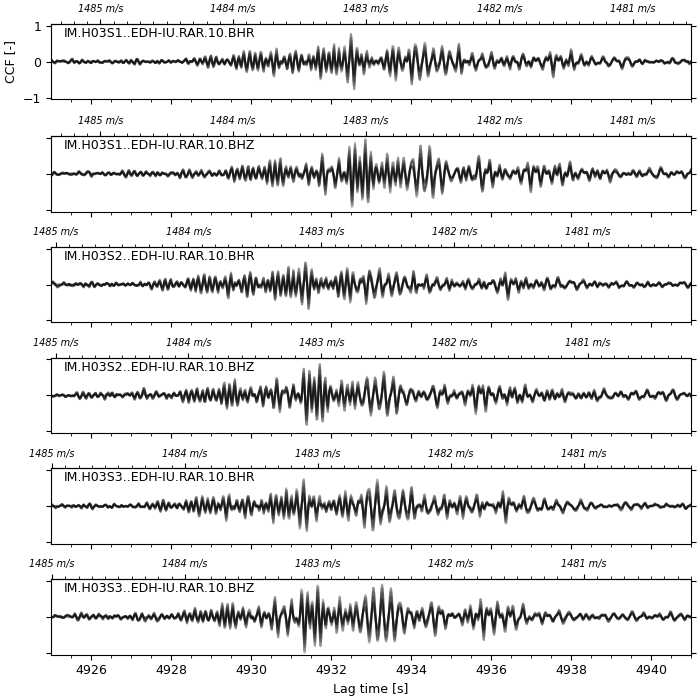

In [10]:
ds = ds1
pairs = ds.pair

c_major = np.arange(1480, 1486, 1)
c_minor = np.arange(1480, 1486, .1)

xlim = (4925, 4941)
ylim = (-1.05, 1.05)
factor = signal1.signal.abs().max()

fig = plt.figure(constrained_layout=True, figsize=(7, len(pairs) + 1))

gs = GridSpec(ds.pair.size, 1, figure=fig)
axis = []
for i, pair in enumerate(pairs):
    ax = fig.add_subplot(gs[i, 0])

    (signal1/factor).sel(pair=pair).plot.line(x='lag', color='k', add_legend=False, alpha=.25, ax=ax)
    ax.set_title(None)
    if i != len(pairs)-1:
        ax.set_xlabel(None)
        ax.tick_params(labelbottom=False)
    
    d = ds.distance.sel(pair=pair).values.item()*1000
    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xticks(d/c_major)
    ax_t.set_xticks(d/c_minor, minor=True)
    ax_t.set_xticklabels([str(c) + ' m/s' for c in c_major], fontsize=7, fontstyle='italic')

    ax.set_ylabel('CCF [-]' if i == 0 else None)
    ax.tick_params(labelleft=i==0)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.text(0.02, 0.96, str(pair.values),
            transform=ax.transAxes, ha='left', va='top')

    axis.append(ax)

plt.show()
fig.savefig(f"figs/H03S_cc_{ds1.time[0].dt.strftime('%Y.%j').values}.pdf", bbox_inches='tight')

<IPython.core.display.Javascript object>


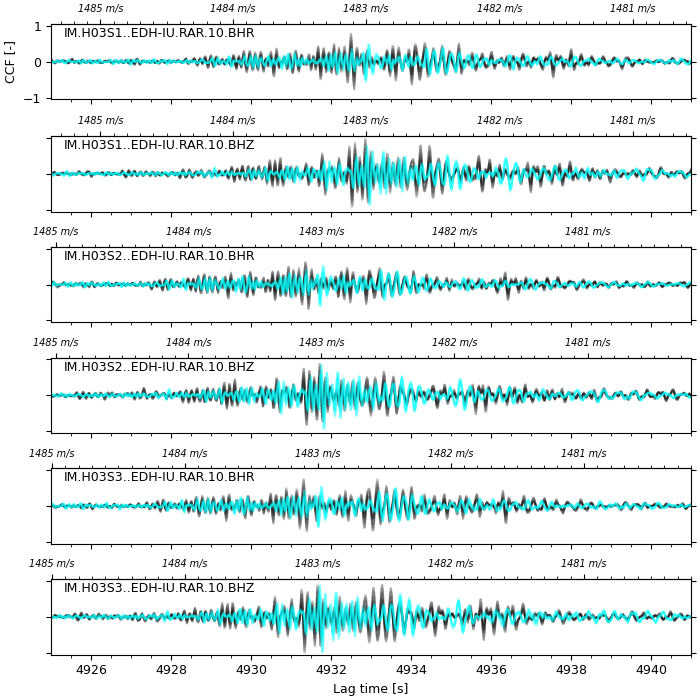

In [11]:
ds = ds1
pairs = ds.pair

c_major = np.arange(1480, 1486, 1)
c_minor = np.arange(1480, 1486, .1)

xlim = (4925, 4941)
ylim = (-1.05, 1.05)

factor1 = signal1.signal.abs().max()
factor2 = signal2.signal.abs().max()
factor = max([factor1, factor2])

fig = plt.figure(constrained_layout=True, figsize=(7, len(pairs) + 1))

gs = GridSpec(ds.pair.size, 1, figure=fig, )
axis = []
for i, pair in enumerate(pairs):
    ax = fig.add_subplot(gs[i, 0])

    if pair.values in signal1.pair:
        (signal1/factor1).sel(pair=pair).plot.line(x='lag', color='k', alpha=.2, add_legend=False, ax=ax)
    if pair.values in signal2.pair:
        (signal2/factor2).sel(pair=pair).plot.line(x='lag', color='cyan', alpha=.2, add_legend=False, ax=ax)
    ax.set_title(None)
    if i != len(pairs)-1:
        ax.set_xlabel(None)
        ax.tick_params(labelbottom=False)
    
    d = ds.distance.sel(pair=pair).values.item()*1000
    ax_t = ax.secondary_xaxis('top')
    ax_t.set_xticks(d/c_major)
    ax_t.set_xticks(d/c_minor, minor=True)
    ax_t.set_xticklabels([str(c) + ' m/s' for c in c_major], fontsize=7, fontstyle='italic')

    ax.set_ylabel('CCF [-]' if i == 0 else None)
    ax.tick_params(labelleft=i==0)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_ticks_position('both')
    ax.text(0.02, 0.96, str(pair.values),
            transform=ax.transAxes, ha='left', va='top')

    axis.append(ax)

plt.show()
fig.savefig(f"figs/H03S_cc_{ds1.time[0].dt.strftime('%Y.%j').values}_vs_{ds2.time[0].dt.strftime('%Y.%j').values}_{offset:.2f}s.pdf", bbox_inches='tight')